In [1]:
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import sys
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import roc_auc_score
import random
import pickle
from sklearn.model_selection import GridSearchCV
import numpy as np
from map4 import MAP4Calculator
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromFASTA, MolToSmiles, MolFromSmiles
from rdkit.Chem import rdchem, Lipinski
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import os
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score,confusion_matrix
folder = "/data/AIpep-clean/"

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# NB, SVM, and RF 

In [2]:
def numTochar(nseq):
    seq = ''
    for num in nseq:
        seq += char_voc_inv[num] 
    return seq

def charTonum(seq):
    nseq = []
    for char in seq:
        nseq.append(char_voc_[char])
    while len(nseq) < 190:
        nseq.append(0)
    return nseq

In [3]:
def train_clf(clf, X, Y, x, y):
    clf = clf.fit(X, Y)
    predicted_training = clf.predict_proba(X)
    predicted_test = clf.predict_proba(x)

    roc_training = roc_auc_score(Y, predicted_training[:,1])
    roc_test = roc_auc_score(y, predicted_test[:,1])

    print("ROC AUC Train: {:.3f}".format(roc_training))
    print("ROC AUC Test: {:.3f}".format(roc_test))
    return clf

In [4]:
def find_threshold(y_true, y_score, alpha = 0.05):
    fpr, tpr, thresh = roc_curve(y_true, y_score)
    for i, fp in enumerate(fpr):
        if fp > alpha:
            return thresh[i-1]
        
def calc_metrics(y_true, y_score, threshold = 0.5):
    y_score = y_score > threshold
    accuracy = accuracy_score(y_true, y_score)
    f1 = f1_score(y_true, y_score)
    mcc = matthews_corrcoef(y_true, y_score)
    precision = precision_score(y_true, y_score)
    recall = recall_score(y_true, y_score)
    matrix = confusion_matrix(y_true, y_score).ravel()
    return accuracy, f1, mcc, precision, recall, matrix

In [5]:
def plt_roc_curve(clf, X, Y, x, y, name):
    predicted_training = clf.predict_proba(X)
    predicted_test = clf.predict_proba(x)
    fpr_test, tpr_test, _ = roc_curve(y, predicted_test[:,1])
    with open(f"/data/AIpep/auc_files/{name}_classifier_hem","bw") as fd:
        pickle.dump((fpr_test, tpr_test), fd)
    
    fpr_training, tpr_training, _ = roc_curve(Y, predicted_training[:,1])
    roc_training = roc_auc_score(Y, predicted_training[:,1])
    roc_test = roc_auc_score(y, predicted_test[:,1])
  
    accuracy, f1, mcc, precision, recall, matrix = calc_metrics(y, predicted_test[:,1])
    print(name, accuracy, precision, recall, f1, mcc, matrix)
    print()
    
    plt.figure()
       
    plt.rcParams.update({'font.size': 15})
    lw = 2
    plt.plot(fpr_training, tpr_training, color='blue',
             lw=lw, label='Training Set ROC AUC = %0.2f' % roc_training)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='Test Set ROC AUC = %0.2f' % roc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([-0.005, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("plots/{}.svg".format(name))
    plt.show()

In [6]:
df_all = pd.read_pickle(folder + "pickles/DAASP_RNN_dataset_with_hemolysis.plk")
df_all = df_all.query("isNotHemolytic==1 or isNotHemolytic==0").copy()

In [7]:
# preparing features for training (X) and test (x)
X_seq = df_all[df_all["Set"] == "training"].Sequence.values
x_seq = df_all[df_all["Set"] == "test"].Sequence.values
# generate prediction for training (Y) and test(y) sets
Y = df_all[df_all["Set"] == "training"].isNotHemolytic.values
y = df_all[df_all["Set"] == "test"].isNotHemolytic.values
Y = np.array(Y, dtype=np.float)
y = np.array(y, dtype=np.float)

In [8]:
len(y)

539

In [9]:
len(df_all.query("isNotHemolytic==1 and Set == 'test'"))

226

In [10]:
len(df_all.query("isNotHemolytic==0 and Set == 'test'"))

313

In [11]:
# generate token vocabularies
count_vect = CountVectorizer(lowercase = False, analyzer = "char")
count_vect.fit(X_seq)
char_voc = count_vect.vocabulary_
char_voc_ = {}
char_voc_inv = {}
for k,v in char_voc.items():
    char_voc_[k] = v + 1
    char_voc_inv[v + 1] = k
char_voc_inv[0] = ''

In [12]:
# generate tokens 
X = np.array(list(map(charTonum, X_seq)))
x = np.array(list(map(charTonum, x_seq)))

In [13]:
len(X[0])

190

### Naive Bayes (NB) classifier (baseline)

In [14]:
NB = train_clf(MultinomialNB(), X, Y, x, y)

ROC AUC Train: 0.592
ROC AUC Test: 0.640


NB 0.5640074211502782 0.48717948717948717 0.7566371681415929 0.5927209705372617 0.1879782539650732 [133 180  55 171]



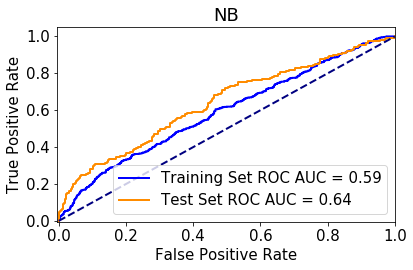

In [15]:
plt_roc_curve(NB,  X, Y, x, y, "NB")

### Support vector model classifier with non linear (rbf) kernel

In [16]:
# SVM optimization for ROC auc
param_grid = {'C': [0.1,1, 10, 100], \
              'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid = GridSearchCV(svm.SVC(probability=True),param_grid, scoring='roc_auc',\
                    refit=True,verbose=2, n_jobs=3)
grid.fit(X,Y)
grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   23.7s
[Parallel(n_jobs=3)]: Done  80 out of  80 | elapsed:   52.8s finished


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [17]:
# Support vector model classifier with non linear (rbf) kernel and optimized gamma and C
SVM = train_clf(svm.SVC(probability=True, gamma = 0.001, C=1), X, Y, x, y)

ROC AUC Train: 0.884
ROC AUC Test: 0.782


SVM 0.7365491651205937 0.7413793103448276 0.5707964601769911 0.645 0.4506715583762817 [268  45  97 129]



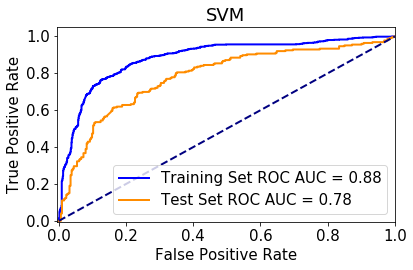

In [18]:
plt_roc_curve(SVM,  X, Y, x, y, "SVM")

### Random forest (RF) classifier

# RF optimization for ROC auc
param_grid = {'max_depth': [10, 30, 50, 70, 90, None], \
              'n_estimators': [10, 100, 250, 500, 750, 1000, 1500, 2000]}
grid = GridSearchCV(RandomForestClassifier(),  param_grid, refit=True,\
                    scoring='roc_auc', verbose=2, n_jobs=3)
grid.fit(X,Y)
grid.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
RF = train_clf(RandomForestClassifier(n_estimators=500, max_depth=10), X, Y, x, y)

ROC AUC Train: 0.981
ROC AUC Test: 0.876


RF 0.7847866419294991 0.8273809523809523 0.6150442477876106 0.7055837563451777 0.5565212065232134 [284  29  87 139]



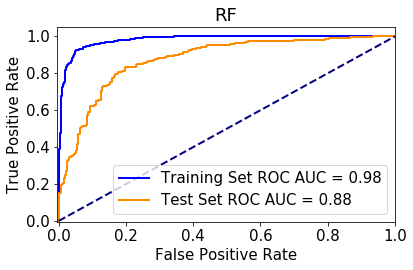

In [20]:
plt_roc_curve(RF,  X, Y, x, y, "RF")